## Estimate trajectory by gp

In [1]:
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import distance_matrix

In [140]:
n = 1000
N = 100
data_seed = 20190701

In [141]:
true_func = lambda t: np.array([np.sin(t), np.cos(t)]).T

In [142]:
### データ生成
np.random.seed(data_seed)
domain_X = (-5, 5)
M = 2

# train_X = np.random.uniform(low=0, high=np.pi, size=(n, 1))
# test_X = np.random.uniform(low=0, high=np.pi, size=(N, 1))

train_X = np.linspace(0, 2*np.pi, num=n).reshape((n, 1))
test_X = np.sort(np.random.uniform(0, 2*np.pi, size=(N,1)), axis=0)
# np.linspace(0, np.pi, num=n).reshape((n, 1))

train_Y = (true_func(train_X.squeeze()) + np.random.normal(scale=0.1, size = (n, M)))
test_Y = (true_func(test_X.squeeze()) + np.random.normal(scale=0.1, size = (N, M)))

In [143]:
def det_subsampling(x:np.ndarray, y:np.ndarray, sub_n:int = 10, seed = -1) -> (np.ndarray, np.ndarray, np.ndarray):
    if seed > 0:
        np.random.seed(seed)
    if sub_n > x.shape[0]:
        raise ValueError("Invalid sample number for sub_n! sub_n should be less than total sample number")
    
    sub_ind = np.argsort(np.random.dirichlet(np.ones(x.shape[0])))[:sub_n]
    
    if x.ndim == 1:
        return(sub_ind, x[sub_ind], y[sub_ind])
    else:
        return(sub_ind, x[sub_ind, :], y[sub_ind])

In [144]:
### 学習部分の設定
learning_seed = 20190703
sug_n = 100
theta1 = 1; theta2 = 0.5; ln_sigma = 1
gauss_kernel = lambda x, y, theta1, theta2: theta1 * np.exp(- theta2 * distance_matrix(x,y, p=2)/2)
gauss_kernel_diag = lambda x,theta1,theta2: theta1

used_kernel = gauss_kernel
used_kernel_diag = gauss_kernel_diag

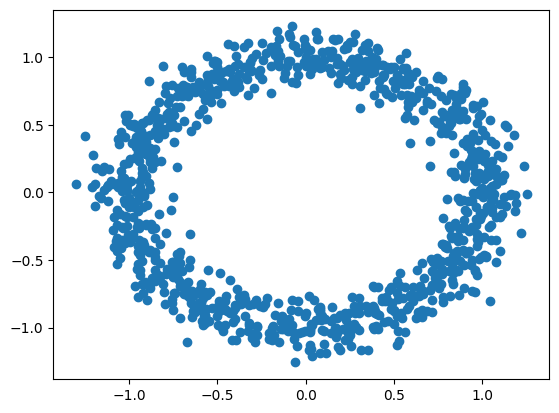

In [145]:
plt.scatter(train_Y[:,0], train_Y[:,1])
# plt.scatter(train_X, true_func(train_X))
# plt.show()

In [146]:
(sub_ind, sub_X, sub_Y) = det_subsampling(train_X, train_Y, sug_n, learning_seed)

In [147]:
sub_train_kernel = used_kernel(sub_X, train_X, theta1, theta2)
sub_sub_kernel = used_kernel(sub_X, sub_X, theta1, theta2)
inv_sub_sub_kernel = np.linalg.inv(sub_sub_kernel)
train_kernel_diag = used_kernel_diag(train_X, theta1, theta2)

In [148]:
prior_var = train_kernel_diag - (sub_train_kernel * (inv_sub_sub_kernel @ sub_train_kernel)).sum(axis=0)
var_yu = prior_var + ln_sigma
inv_var_yu = 1/var_yu

In [149]:
Q = sub_sub_kernel + np.einsum("ik, jk, k -> ij", sub_train_kernel, sub_train_kernel, inv_var_yu)
inv_Q = np.linalg.inv(Q)

In [150]:
est_cov = sub_sub_kernel @ inv_Q @ sub_sub_kernel
est_inv_cov = inv_sub_sub_kernel @ Q @ inv_sub_sub_kernel

In [151]:
est_u = sub_sub_kernel @ inv_Q @ sub_train_kernel @ (inv_var_yu[:,np.newaxis] * train_Y)

In [152]:
test_sub_kernel = used_kernel(test_X, sub_X, theta1, theta2)
test_kernel_diag = used_kernel_diag(test_X, theta1, theta2)

In [153]:
pred_mean_Y = test_sub_kernel @ inv_sub_sub_kernel @ est_u
pred_var_Y = test_kernel_diag - (test_sub_kernel * (test_sub_kernel @ est_inv_cov)).sum(axis = 0)

In [154]:
np.sqrt(((test_Y - pred_mean_Y)**2).sum(axis=1)).mean()

0.12318278018281135

In [155]:
np.sqrt(((test_Y - pred_mean_Y)**2).sum(axis=1)).mean()

0.12318278018281135

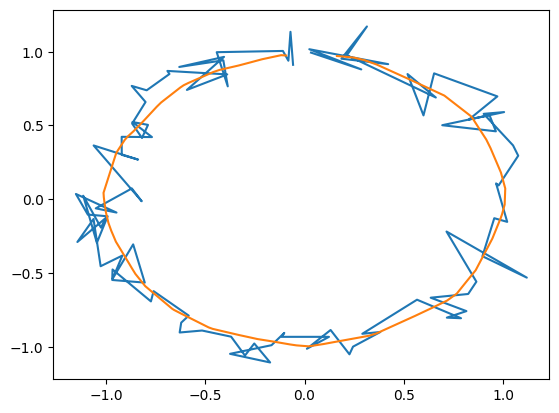

In [157]:
plt.plot(test_Y[:,0], test_Y[:,1])
plt.plot(pred_mean_Y[:,0], pred_mean_Y[:,1])